# Sesión 13 B

## Estimación de parámetros en redes bayesianas

> **Objetivos:**
> - Obtener los parámetros de máxima verosimilitud para redes Bayesianas.
> - Obtener los parámetros MAP para redes Bayesianas.

> **Referencias:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 17.

### 1. Introducción

Una vez que la **estructura** de una red bayesiana está definida, el siguiente paso es **aprender sus parámetros**, es decir, las probabilidades que conforman las *Conditional Probability Distributions* (CPDs) de cada nodo.

Suponemos que disponemos de un conjunto de datos completamente observados:

$$
\mathcal{D} = \{d_1, d_2, \ldots, d_N\}
$$

Cada instancia contiene un valor para cada nodo de la red.  

El objetivo del aprendizaje de parámetros es encontrar los valores de las probabilidades que **mejor explican** los datos observados.

Este problema aparece frecuentemente cuando:
- un experto puede definir la **estructura**, pero no los valores numéricos de las probabilidades,
- queremos ajustar el modelo a **datos reales**,
- necesitamos estos parámetros como parte de procedimientos más complejos (p. ej., aprendizaje de estructura o aprendizaje con datos incompletos).

Existen dos enfoques principales para estimar parámetros:

> **1. Estimación por Máxima Verosimilitud (MLE)**  
> **2. Estimación Bayesiana (MAP / Dirichlet priors)**

#### 1.1 Estimación por Máxima Verosimilitud (MLE)

La idea es simple: elegir los parámetros que **hacen más probable el dataset** bajo el modelo.

Buscamos:
$$
\theta^{*}=\arg\max_\theta P(\mathcal{D}\mid\mathcal{M}(\theta))
$$

Con datos i.i.d.:
$$
P(\mathcal{D}\mid\mathcal{M})=\prod_{m=1}^N P(d_m\mid\mathcal{M})
$$

MLE solo dice: *“ajusta $\theta$ para que lo que viste en los datos sea lo más probable posible”*.

##### 1.1.1. MLE en redes bayesianas discretas

Cada nodo discreto (con o sin padres) genera **conteos** de sus valores observados.

La verosimilitud es la de una **multinomial**: multiplicamos la probabilidad de cada valor **tantas veces como aparece en el dataset**.

Para un nodo con padres $U$:
$$
L(\theta)=\prod_{x,u}\theta_{x\mid u}^{\,N(x,u)}
$$

Para un nodo sin padres:
$$
L(\theta)=\prod_x \theta_x^{\,N(x)}
$$

El máximo siempre se obtiene **normalizando los conteos**:

- Con padres:
  $$\hat\theta_{x\mid u}=\frac{N(x,u)}{N(u)}$$

el estimador de máxima verosimilitud corresponde a la cantidad de muestras consistentes con $x$ y $u$ dividido entre la cantidad de muestras consistentes con $u$.

- Sin padres:
  $$\hat\theta_x=\frac{N(x)}{N}$$

> **MLE = frecuencias relativas.**  
> Porque para datos categóricos, la multinomial dice: *“usa como probabilidad la proporción con la que lo viste ocurrir”*.

##### 1.1.2. Ejemplo 1: nodo **sin padres**

El nodo $X$ toma valores $\{0,1,2\}$. En el dataset observamos:

| $X$ | Conteo |
|-----|--------|
| 0   | 40     |
| 1   | 35     |
| 2   | 25     |

Total:  
$$N=40+35+25=100$$

MLE:
$$
\hat\theta_0=\tfrac{40}{100}=0.40,\quad
\hat\theta_1=\tfrac{35}{100}=0.35,\quad
\hat\theta_2=\tfrac{25}{100}=0.25
$$

##### 1.1.3. Ejemplo 2: nodo **con padres**

Supón que $X$ tiene un padre $U$. Miramos solo las filas donde $U=u$:

| $X$ | $U=u$ | Conteo $N(x,u)$ |
|-----|-------|-----------------|
| 0   |   u   | 30              |
| 1   |   u   | 50              |
| 2   |   u   | 20              |

Total dado $u$:  
$$N(u)=100$$

MLE:
$$
\hat\theta_{0\mid u}=\tfrac{30}{100}=0.30,\quad
\hat\theta_{1\mid u}=\tfrac{50}{100}=0.50,\quad
\hat\theta_{2\mid u}=\tfrac{20}{100}=0.20
$$

> En ambos casos: **frecuencias relativas = parámetros MLE**

#### 1.2. Conexión con el `.fit()` de pgmpy

El método:

``.fit`` de pgmpy implementa exactamente este procedimiento de MLE para redes bayesianas con datos completamente observados.

En este caso vamos a generar un ejemplo de ``Naive Bayes`` usando el dataset de vinos y poniendo atención en la estimación de los parámetros mediante MLE.

In [2]:
from pgmpy.models import DiscreteBayesianNetwork
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
import os
ruta = os.path.join('..', 'data', 'winequality-red.csv')
wine_data = pd.read_csv(ruta, sep=";")

In [4]:
wine_data.shape

(1599, 12)

In [5]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<Axes: >

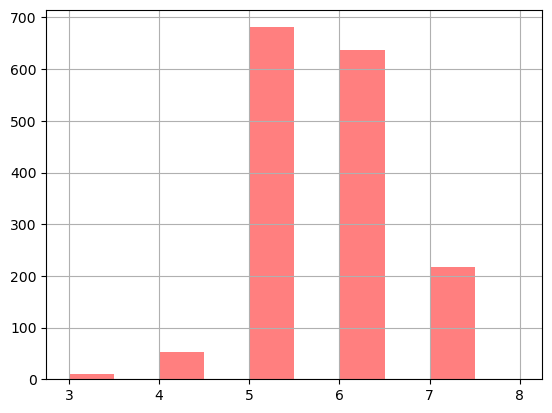

In [6]:
# histograma de la variable objetivo
wine_data["quality"].hist(
                        bins=5,
                        color="red",
                        alpha=0.5,
                        width=0.5)

![wine-results](../images/wine.png)

In [7]:
# target
target = "quality"

# vars independientes
variables = [col for col in wine_data.columns if col != target]

print('Target:', target)
print('Variables independientes:', variables)

Target: quality
Variables independientes: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [8]:
# pandas qcut
pd.qcut?

Signature:
pd.qcut(
    x,
    q,
    labels=None,
    retbins: 'bool' = False,
    precision: 'int' = 3,
    duplicates: 'str' = 'raise',
)
Docstring:
Quantile-based discretization function.

Discretize variable into equal-sized buckets based on rank or based
on sample quantiles. For example 1000 values for 10 quantiles would
produce a Categorical object indicating quantile membership for each data point.

Parameters
----------
x : 1d ndarray or Series
q : int or list-like of float
    Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately
    array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.
labels : array or False, default None
    Used as labels for the resulting bins. Must be of the same length as
    the resulting bins. If False, return only integer indicators of the
    bins. If True, raises an error.
retbins : bool, optional
    Whether to return the (bins, labels) or not. Can be useful if bins
    is given as a scalar.
precision : int, optional
    

> **Nota:** En este ejemplo usamos el mismo número de cuantiles para todas las variables solo para simplificar. En la práctica, cada variable debería discretizarse según su propia distribución (no todas requieren la misma cantidad ni el mismo tipo de cortes).

In [9]:
# Quantización de variables numéricas
quantiles = 10
for col in variables:
    wine_data[col] = pd.qcut(wine_data[col], q=quantiles, labels=range(1, 11))
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,4,9,1,3,4,4,5,8,9,3,2,5
1,5,10,1,8,9,9,8,6,3,7,4,5
2,5,10,2,6,8,6,7,6,4,6,4,5
3,10,1,10,3,4,7,8,8,2,4,4,6
4,4,9,1,3,4,4,5,8,9,3,2,5


In [10]:
wine_data['quality'].value_counts().sort_index()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

In [11]:
wine_data['volatile acidity'].value_counts().sort_index()

volatile acidity
1     175
2     161
3     145
4     171
5     164
6     148
7     161
8     159
9     157
10    158
Name: count, dtype: int64

In [13]:
# Red Bayesiana
wine_model_naive = DiscreteBayesianNetwork([
    ('quality', 'fixed acidity'),
    ('quality', 'volatile acidity'),
    ('quality', 'citric acid'),
    ('quality', 'residual sugar'),
    ('quality', 'chlorides'),
    ('quality', 'free sulfur dioxide'),
    ('quality', 'total sulfur dioxide'),
    ('quality', 'density'),
    ('quality', 'pH'),
    ('quality', 'sulphates'),
    ('quality', 'alcohol'),
])

> Aquí dejo la [documentación](https://pgmpy.org/plotting.html) acerca de `plotting models` de pgmpy.

<Axes: >

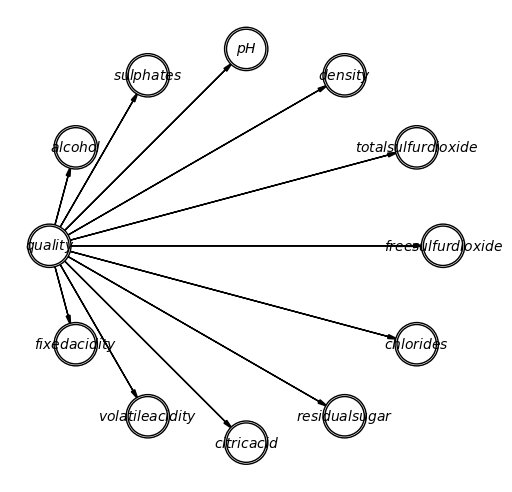

In [14]:
# Dibujar red con daft
model_plot = wine_model_naive.to_daft(
    node_pos="shell",
    pgm_params={"observed_style": "outer", "grid_unit": 5}
)
model_plot.render()

In [15]:
# Train y test
train_df = wine_data.sample(frac=0.8, random_state=42)
test_df = wine_data.drop(train_df.index)
train_df.shape, test_df.shape

((1279, 12), (320, 12))

* **nota que aquí usamos el `.fit()` de pgmpy para estimar los parámetros de la red bayesiana usando MLE.**

In [16]:
# Entrenamos
wine_model_naive.fit(train_df)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fixed acidity': 'O', 'volatile acidity': 'O', 'citric acid': 'O', 'residual sugar': 'O', 'chlorides': 'O', 'free sulfur dioxide': 'O', 'total sulfur dioxide': 'O', 'density': 'O', 'pH': 'O', 'sulphates': 'O', 'alcohol': 'O', 'quality': 'N'}


In [17]:
wine_model_naive.check_model()

True

In [18]:
# CPDs estimadas -- target
print(wine_model_naive.get_cpds(target))

+------------+------------+
| quality(3) | 0.00547303 |
+------------+------------+
| quality(4) | 0.03362    |
+------------+------------+
| quality(5) | 0.433151   |
+------------+------------+
| quality(6) | 0.388585   |
+------------+------------+
| quality(7) | 0.12588    |
+------------+------------+
| quality(8) | 0.0132916  |
+------------+------------+


In [20]:
# train value counts -- target
train_df[target].value_counts(normalize=True).sort_index()

quality
3    0.005473
4    0.033620
5    0.433151
6    0.388585
7    0.125880
8    0.013292
Name: proportion, dtype: float64

In [21]:
# CPDs estimadas -- alcohol | target
print(wine_model_naive.get_cpds("alcohol"))

+-------------+---------------------+-----+----------------------+
| quality     | quality(3)          | ... | quality(8)           |
+-------------+---------------------+-----+----------------------+
| alcohol(1)  | 0.14285714285714285 | ... | 0.0                  |
+-------------+---------------------+-----+----------------------+
| alcohol(2)  | 0.0                 | ... | 0.0                  |
+-------------+---------------------+-----+----------------------+
| alcohol(3)  | 0.0                 | ... | 0.0                  |
+-------------+---------------------+-----+----------------------+
| alcohol(4)  | 0.2857142857142857  | ... | 0.058823529411764705 |
+-------------+---------------------+-----+----------------------+
| alcohol(5)  | 0.14285714285714285 | ... | 0.058823529411764705 |
+-------------+---------------------+-----+----------------------+
| alcohol(6)  | 0.0                 | ... | 0.0                  |
+-------------+---------------------+-----+-------------------

In [22]:
pd.DataFrame(
    data=wine_model_naive.get_cpds("alcohol").values,
    columns=[f"{target}_{i}" for i in range(3, 9)],
    index=[f"alcohol_{i}" for i in range(1, 11)]
)

,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8
alcohol_1,0.142857,0.209302,0.184116,0.112676,0.012422,0.000000
alcohol_2,0.000000,0.023256,0.263538,0.106640,0.006211,0.000000
alcohol_3,0.000000,0.116279,0.054152,0.030181,0.000000,0.000000
alcohol_4,0.285714,0.116279,0.146209,0.094567,0.037267,0.058824
alcohol_5,0.142857,0.093023,0.106498,0.098592,0.074534,0.058824
alcohol_6,0.000000,0.069767,0.084838,0.098592,0.055901,0.000000
alcohol_7,0.285714,0.069767,0.054152,0.118712,0.111801,0.000000
alcohol_8,0.142857,0.139535,0.055957,0.104628,0.186335,0.176471
alcohol_9,0.000000,0.139535,0.032491,0.150905,0.248447,0.235294
alcohol_10,0.000000,0.023256,0.018051,0.084507,0.267081,0.470588


In [23]:
predictions = wine_model_naive.predict(test_df.drop(columns=[target]))

d:\anaconda3\envs\mgp\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(
d:\anaconda3\envs\mgp\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(


  0%|          | 0/307 [00:00<?, ?it/s]

In [24]:
predictions

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,5,10,1,8,9,9,8,6,3,7,4,5
8,5,7,2,3,4,3,2,6,7,4,2,5
13,5,7,6,1,10,3,4,7,4,10,1,5
14,7,8,4,10,10,10,10,9,2,10,1,5
20,7,1,9,2,5,9,8,6,8,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1,5,4,3,1,6,5,1,9,4,9,6
1570,1,2,10,5,10,7,5,1,7,10,10,7
1573,1,7,4,7,4,6,7,2,10,7,10,6
1583,1,4,6,4,4,10,10,3,6,5,4,5


In [25]:
predictions['quality'].values == test_df['quality'].values

array([ True, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False,  True, False,  True, False, False,  True, False, False,
       False,  True, False,  True, False, False, False,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True, False,  True, False, False,
        True,  True,  True, False,  True, False,  True, False, False,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True,

In [26]:
(predictions['quality'].values == test_df['quality'].values).mean()

np.float64(0.63125)

#### 1.3. `fit_update`

Algo muy interesante del método `fit` de **pgmpy** es que permite un ajuste **incremental** de los parámetros.

_¿Qué significa esto?_  
Que el modelo puede **actualizar sus CPDs con nuevos datos sin volver a entrenar desde cero**. 
 
Es exactamente la idea de aprendizaje **online** o **incremental**: procesar datos que llegan en bloques o secuencias, manteniendo el modelo al día sin reconstruirlo completamente.

Esto es útil cuando:
- El dataset crece con el tiempo.
- Entrenar desde cero sería costoso.
- Queremos modelos que se adapten continuamente.

Aquí está la documentación del método [`fit_update`](https://pgmpy.org/models/bayesiannetwork.html#pgmpy.models.DiscreteBayesianNetwork.DiscreteBayesianNetwork.fit_update).


### 2. Estimación MAP

#### 2.1. ¿Cómo prevenimos el _overfitting_?

MLE copia **exactamente** las frecuencias del dataset.
Si el dataset es pequeño o hay combinaciones poco frecuentes (tienden a cero) → las probabilidades quedan **extremas** y el modelo **sobreajusta**.

**Solución:** introducir *suavizado* mediante **regularización / priors** (p. ej., Dirichlet). Esto evita ceros, reparte _probabilidad_ antes de ver datos y produce parámetros más estables.

##### 2.1.1 ¿Qué es la prior Dirichlet?

Queremos modelar una distribución multinomial con parámetros $\bar{\theta} = [\theta_1,\dots,\theta_k]$.
Estas $\theta_i$ son **probabilidades**, así que deben sumar 1 y ser ≥ 0.

_Dirichlet_ es simplemente una **distribución sobre vectores de probabilidad**. 

Es decir:

> La Dirichlet describe “cómo creemos que deberían ser las probabilidades” antes de ver los datos.


##### 2.1.2 ¿Qué significan sus parámetros?

La Dirichlet tiene hiperparámetros $\alpha_1,\dots,\alpha_k$ y su interpretación intuitiva es:

- Cada $\alpha_i$ funciona como **cuántas veces creo que ocurrió la categoría $i$ antes de ver datos reales**.
- Por eso se conocen como **conteos ficticios** _(pseudo-counts)_.

Ejemplo:  

si $\alpha = [1,1,1]$ → no tengo preferencias (todo es uniforme).

si $\alpha = [10,1,1]$ → creo fuertemente que la categoría 1 es más probable.



##### 2.1.3 ¿Cómo actualiza la Dirichlet con los datos?

Si contamos en los datos reales cuántas veces apareció cada categoría $i$: 

- $N_i$ = conteos reales

Entonces la actualización posterior es:

$$
\hat\theta_i = \frac{N_i + \alpha_i}{\sum_j (N_j + \alpha_j)}
$$

Es decir:

> **Probabilidad = (conteos reales + conteos ficticios) / total.**

Muy simple:  
- Los datos suman evidencia.  
- La prior agrega “un pequeño empujón” que evita ceros y reduce overfitting.

> **Dirichlet = multinomial suavizada.**  
>  
> Toma las frecuencias reales y les agrega un poquito de evidencia previa para no sobreajustar.

Es exactamente lo que necesitas cuando:
- tienes pocos datos,
- aparecen valores raros,
- quieres evitar probabilidades 0,
- quieres un modelo más generalizable.

- Estimadores MAP son menos sensibles al ruido en los datos.

- Estimador MAP $\to$ estimador de máxima verosimilitud cuando el número de muestras $\to \infty$.

In [27]:
from pgmpy.estimators import BayesianEstimator

In [28]:
help(BayesianEstimator)

Help on class BayesianEstimator in module pgmpy.estimators.BayesianEstimator:

class BayesianEstimator(pgmpy.estimators.base.ParameterEstimator)
 |  BayesianEstimator(model, data, **kwargs)
 |
 |  Class used to compute parameters for a model using Bayesian Parameter Estimation.
 |  See `MaximumLikelihoodEstimator` for constructor parameters.
 |
 |  Method resolution order:
 |      BayesianEstimator
 |      pgmpy.estimators.base.ParameterEstimator
 |      pgmpy.estimators.base.BaseEstimator
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, model, data, **kwargs)
 |      Base class for parameter estimators in pgmpy.
 |
 |      Parameters
 |      ----------
 |      model: pgmpy.models.DiscreteBayesianNetwork or pgmpy.models.MarkovNetwork model
 |          for which parameter estimation is to be done.
 |
 |      data: pandas DataFrame object
 |          dataframe object with column names identical to the variable names of the model.
 |          (If some values in t

In [29]:
estimator = BayesianEstimator(
    model=wine_model_naive,
    data=train_df
)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fixed acidity': 'O', 'volatile acidity': 'O', 'citric acid': 'O', 'residual sugar': 'O', 'chlorides': 'O', 'free sulfur dioxide': 'O', 'total sulfur dioxide': 'O', 'density': 'O', 'pH': 'O', 'sulphates': 'O', 'alcohol': 'O', 'quality': 'N'}


##### 2.1.4. Los _pseudo-counts_ (los $\alpha$ de Dirichlet)

* **Cada nodo tiene 6 categorías**

In [30]:
train_df[target].nunique()

6

In [31]:
np.ones((train_df[target].nunique(), 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

* **10 es un hiperparámetro que define la fuerza del prior Dirichlet.**

In [32]:
np.ones((train_df[target].nunique(), 1)) * 10

array([[10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.]])

Supongamoss que los conteos reales fueron:

| Categoría | Conteo real $N_i$ |
|-----------|-------------------|
| 0         | 50                |
| 1         | 30                |
| 2         | 20                |
| 3         | 10                |
| 4         | 5                 |
| 5         | 1                 |

Prior Dirichlet utilizado es:

$$
\alpha_i = 10 \quad \forall i
$$

La actualización posterior es:

$$
\alpha'_i = N_i + 10
$$

Y la CPD resultante (la media posterior del Dirichlet) es:

$$
P(i) = \frac{N_i + 10}{\sum_j (N_j + 10)}
$$

Esto equivale a suponer que:

> Antes de ver datos, he observado 10 veces cada categoría

In [33]:
# Estimar CPDs con previa de Dirichlet

cpd_quality = estimator.estimate_cpd(
    node=target,
    prior_type="dirichlet",
    pseudo_counts=10 * np.ones((train_df[target].nunique(), 1))
)
print(cpd_quality)

+------------+-----------+
| quality(3) | 0.012696  |
+------------+-----------+
| quality(4) | 0.0395818 |
+------------+-----------+
| quality(5) | 0.42121   |
+------------+-----------+
| quality(6) | 0.378641  |
+------------+-----------+
| quality(7) | 0.127707  |
+------------+-----------+
| quality(8) | 0.0201643 |
+------------+-----------+


In [34]:
#para comparar
print(wine_model_naive.get_cpds(target))

+------------+------------+
| quality(3) | 0.00547303 |
+------------+------------+
| quality(4) | 0.03362    |
+------------+------------+
| quality(5) | 0.433151   |
+------------+------------+
| quality(6) | 0.388585   |
+------------+------------+
| quality(7) | 0.12588    |
+------------+------------+
| quality(8) | 0.0132916  |
+------------+------------+


In [35]:
cpd_cols = {}
for col in variables:
    cpd_cols[col] = estimator.estimate_cpd(
        node=col,
        prior_type="dirichlet",
        pseudo_counts=10 * np.ones((train_df[col].nunique(), train_df[target].nunique()))
    )
print(cpd_cols[col])

+-------------+---------------------+-----+---------------------+
| quality     | quality(3)          | ... | quality(8)          |
+-------------+---------------------+-----+---------------------+
| alcohol(1)  | 0.102803738317757   | ... | 0.08547008547008547 |
+-------------+---------------------+-----+---------------------+
| alcohol(2)  | 0.09345794392523364 | ... | 0.08547008547008547 |
+-------------+---------------------+-----+---------------------+
| alcohol(3)  | 0.09345794392523364 | ... | 0.08547008547008547 |
+-------------+---------------------+-----+---------------------+
| alcohol(4)  | 0.11214953271028037 | ... | 0.09401709401709402 |
+-------------+---------------------+-----+---------------------+
| alcohol(5)  | 0.102803738317757   | ... | 0.09401709401709402 |
+-------------+---------------------+-----+---------------------+
| alcohol(6)  | 0.09345794392523364 | ... | 0.08547008547008547 |
+-------------+---------------------+-----+---------------------+
| alcohol(

* **¿Por qué todos los $\alpha_i$ son iguales?**

> Porque queremos un prior **no informativo** que no favorezca ninguna categoría en particular.

En este caso estamos usando un prior **simétrico** (todos los $\alpha_i$ iguales) que no favorece ninguna categoría.

Sin embargo, podríamos usar **priors asimétricos** si tuviéramos conocimiento previo que favoreciera ciertas categorías.

Por ejemplo:

```python
pseudo_counts = np.array([[20],[10],[5],[2],[1],[1]])
```

* **Como usualmente hacemos, agregamos o sumamos las cpds al modelo:**

In [36]:
# Añadimos CPDs
wine_model_naive.add_cpds(cpd_quality, * cpd_cols.values())
wine_model_naive.check_model()

True

* **Generamos las predicciones:**

In [37]:
predictions = wine_model_naive.predict(test_df.drop(columns=[target]))

d:\anaconda3\envs\mgp\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(
d:\anaconda3\envs\mgp\Lib\site-packages\pgmpy\models\DiscreteBayesianNetwork.py:720: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_unique_indexes = data.groupby(list(data.columns), dropna=False).apply(


  0%|          | 0/307 [00:00<?, ?it/s]

In [38]:
predictions

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,5,10,1,8,9,9,8,6,3,7,4,5
8,5,7,2,3,4,3,2,6,7,4,2,5
13,5,7,6,1,10,3,4,7,4,10,1,5
14,7,8,4,10,10,10,10,9,2,10,1,5
20,7,1,9,2,5,9,8,6,8,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1,5,4,3,1,6,5,1,9,4,9,6
1570,1,2,10,5,10,7,5,1,7,10,10,7
1573,1,7,4,7,4,6,7,2,10,7,10,6
1583,1,4,6,4,4,10,10,3,6,5,4,5


In [39]:
predictions['quality'].values == test_df['quality'].values

array([ True, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False,  True, False,  True, False, False,  True, False, False,
       False,  True, False,  True, False, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True, False,  True, False, False,
        True,  True,  True, False,  True, False,  True, False, False,
        True, False, False, False, False, False,  True,  True,  True,
        True,  True,

In [40]:
# accuracy
(predictions['quality'].values == test_df['quality'].values).mean()

np.float64(0.6375)